In [ ]:
import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

import ast
import math

## Single

In [53]:
def parse_quality_report(file_path):
    """Parses a CheckM2 quality report and extracts completeness & contamination."""
    df = pd.read_csv(file_path, sep="\t")
    df = df[df["Contamination"] < 5]
    return df["Completeness"].values


def process_all_reports(model_results_dir):
    """Walks through the model_results_dir to collect all models and datasets."""
    data = {}

    for dataset in os.listdir(model_results_dir):
        dataset_path = os.path.join(model_results_dir, dataset, "checkm2")
        if not os.path.isdir(dataset_path):
            continue

        for model in os.listdir(dataset_path):
            report_path = os.path.join(dataset_path, model, "quality_report.tsv")
            if not os.path.isfile(report_path):
                continue

            completeness_values = parse_quality_report(report_path)
            bin_counts = [
                int(np.sum(completeness_values >= b)) for b in ['>90%', '>80%', '>70%', '>60%', '>50%']
            ]

            if dataset not in data:
                data[dataset] = {}
            data[dataset][model] = bin_counts

    return data

In [54]:
#path = os.path.join(BASE_DIR,'cami2_benchmark', 'model_results', 'urogenital_short', 'checkm2', 'dnaberth_400k_results', 'quality_report.tsv')
path = os.path.join('quality_report_t2dew_6samples.tsv')
k = parse_quality_report(path)

In [55]:
bin_counts = [
                int(np.sum(k >= b)) for b in [90, 80, 70, 60, 50]
            ]

In [56]:
bin_counts

[2, 3, 4, 7, 8]

## Setup for all Figs

In [27]:
BASE_DIR = '..'
RESULTS_DIR = os.path.join(BASE_DIR,'cami2_benchmark', 'model_results', 'parsed_results')
OUT_DIR = os.path.join(BASE_DIR, 'figures')

DATASET_ORDER = [
    'airways_short',
    'gastro_short',
    'oral_short',
    'urogenital_short',
    'skin_short',
    'marine_short',
    'plant_short',
    'metahit'
]

MODELS = ['dnaberth_400k','dnaberts', 'dnabert2', 'dnabert2random', 'tnf', 'tnfkernel', 'dna2vec']
MODEL_NAMES = ['DNABERT-H 400k', 'DNABERT-S', 'DNABERT-2', 'DNABERT2-Random', 'TNF', 'TNF-Kernel', 'DNA2Vec']

## CheckM2 Results

In [28]:
with open(os.path.join(RESULTS_DIR, 'parsed_checkm2_results.json'), 'r') as f:
    checkm2_data = json.load(f)
    
na_metahit = ['vamb_results', 'taxvamb_results', 'comebin_results']
if 'metahit' in checkm2_data:
    for method in na_metahit:
        if method not in checkm2_data['metahit']:
            checkm2_data['metahit'][method] = [-1] * len(checkm2_data['metahit']['dnabert2_results'])
            
na_marine = ['comebin_results']
if 'marine_short' in checkm2_data:
    for method in na_marine:
        if method not in checkm2_data['marine_short']:
            checkm2_data['marine_short'][method] = [-1] * len(checkm2_data['marine_short']['dnabert2_results'])

In [30]:
completeness_levels = ['>90%', '>80%', '>70%', '>60%', '>50%']
colors = ['#005f5f', '#008c8c', '#66c2c2', '#a0e6e6', '#d9fafa']

cami2_model_names = {
    'vamb_results': 'VAMB',
    'taxvamb_results': 'TaxVAMB',
    'comebin_results': 'Comebin',
    'dnaberts_results': 'DNABERT-S',
    'dnaberth_400k_results': 'DNABERT-H 400k',
    'dnabert2_results': 'DNABERT-2',
    'dnabert2random_results': 'DNABERT2-Random',
    'tnf_results': 'TNF',
    'tnfkernel_results': 'TNF-Kernel',
    'dna2vec_results': 'DNA2Vec'
}

C:\Users\ah140\AppData\Local\Temp\ipykernel_1600\3111748047.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


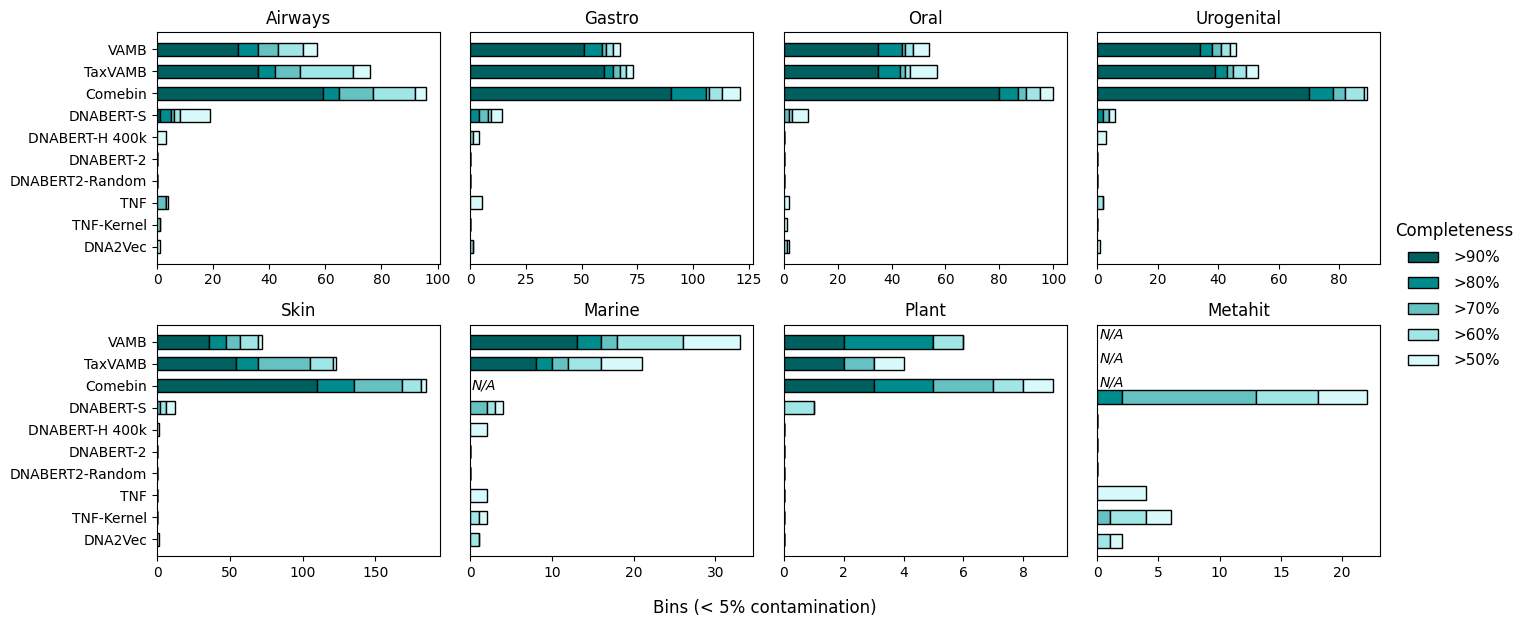

In [53]:
n_cols = 4
n_rows = int((len(DATASET_ORDER) + n_cols - 1) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6), constrained_layout=True)
axes = axes.flatten()

max_total = 0

for idx, domain in enumerate(DATASET_ORDER):
    methods = checkm2_data[domain]
    
    # Filter and sort method names based on custom order
    method_names = [m for m in cami2_model_names.keys() if m in methods]
    y_pos = list(range(len(method_names)))
    
    left = [0] * len(method_names)
    ax = axes[idx]
    
    for i, comp in enumerate(completeness_levels):
        if domain not in ['marine_short','metahit']:
            if i == 0:
                values = [methods[m][i] for m in method_names]
            else:
                values = [methods[m][i] - methods[m][i - 1] for m in method_names]
            
            ax.barh(y_pos, values, left=left, color=colors[i], edgecolor='black', height=0.6)
            left = [l + v for l, v in zip(left, values)]
            
        elif domain in ['marine_short','metahit']:
            values = []
            for m in method_names:
                if methods[m][0] == -1:
                    values.append(None)
                elif i == 0:
                    values.append(methods[m][i])
                else:
                    values.append(methods[m][i] - methods[m][i - 1])

            for j, val in enumerate(values):
                if val is not None:
                    ax.barh(j, val, left=left[j], color=colors[i], edgecolor="black", height=0.6)
                    left[j] += val

    # For metahit: show "N/A" if method data is -1
    if domain in ['metahit']:
        for j, m in enumerate(method_names):
            if methods[m][0] == -1:
                ax.text(1.2, j+0.4, "N/A", va="center", ha="center", fontsize=10, color="black", fontstyle="italic")
    if domain in ['marine_short']:
        for j, m in enumerate(method_names):
            if methods[m][0] == -1:
                ax.text(1.7, j, "N/A", va="center", ha="center", fontsize=10, color="black", fontstyle="italic")


    ax.set_title(domain.replace('_short', '').capitalize())

    if idx % n_cols == 0:
        ax.set_yticks(y_pos)
        ax.set_yticklabels([cami2_model_names.get(m, m.replace('_results', '')) for m in method_names])
    else:
        ax.set_yticks(y_pos)
        ax.set_yticklabels([])
        ax.tick_params(left=False)

    ax.invert_yaxis()
    max_total = max(max_total, max(left))

for i in range(len(DATASET_ORDER), len(axes)):
    fig.delaxes(axes[i])

legend_labels = [f'{level}' for level in completeness_levels]  # Do NOT reverse
legend_patches = [Patch(facecolor=c, edgecolor='black', label=l) for c, l in zip(colors, legend_labels)]

fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(0.99, 0.5),
           title='Completeness', frameon=False, handletextpad=1, labelspacing=0.7, fontsize=11, title_fontsize=12)

fig.text(0.55, -0.03, "Bins (< 5% contamination)", fontsize=12, ha='center')

plt.tight_layout()
plt.show()

## KNN Histograms

In [11]:
with open(os.path.join(RESULTS_DIR, 'parsed_knn_histograms.json'), 'r') as f:
    knn_data = json.load(f)

In [12]:
def modify_histogram_data(dataset_dict):
    """
    Adds a 0 and 1 to the start and end of the pairsim_vector and bin_vector
    """
    
    for dataset_name, models in dataset_dict.items():
        for model_name, model_data in models.items():
            # Modify pairsim_vector by adding 0 at the start and 1 at the end
            if "pairsim_vector" in model_data:
                model_data["pairsim_vector"] = [0] + model_data["pairsim_vector"] + [1]
            
            # Modify bin_vector by adding 0 at both the start and end
            if "bin_vector" in model_data:
                model_data["bin_vector"] = [0] + model_data["bin_vector"] + [0]

    return dataset_dict

In [16]:
def plot_histograms(dataset_dict, selected_models: list, selected_MODEL_NAMES:list):
    """
    Plots histograms for the selected models of each dataset.

    Args:
        dataset_dict (dict): Dictionary where the key is the dataset name and value is a 
                             dictionary of models and associated histogram data.
    """
    dataset_dict = modify_histogram_data(dataset_dict)
    color_thres = 'darkred'
    n_datasets = len(dataset_dict)
    n_models = len(selected_models)

    fig, axes = plt.subplots(n_datasets, n_models, figsize=(10, 2 * n_datasets), squeeze=False)

    for i, (dataset_name, models) in enumerate(dataset_dict.items()):
        for j, (model_name, model_namepretty) in enumerate(zip(selected_models, selected_MODEL_NAMES)):

            ax = axes[i, j]

            x_data = models[model_name].get("pairsim_vector", None)
            y_data = models[model_name].get("bin_vector", None)
            threshold = models[model_name].get("knn_threshold", None)
            k = models[model_name].get("k", None)
            p = models[model_name].get("p", None)

            #histogram
            ax.plot(x_data, y_data, color='steelblue', linestyle='-', linewidth=2)
            ax.fill_between(x_data, y_data, color='steelblue', alpha=0.3)

            # Add k, p box
            ax.text(
                0.04, 0.96, f'k={k}, p={p}', 
                transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray', alpha=0.6)
            )

            # Threshold line and annotation
            ax.axvline(threshold, color=color_thres, linestyle='--', label=f'Threshold: {threshold:.2f}')
            if model_name in ['aa']:
                ax.text(threshold + 0.04, 0.8 * max(ax.get_ylim()), f'{threshold:.2f}', color=color_thres, fontsize=11, ha='left')
                ax.plot([threshold + 0.04, threshold + 0.04 + 0.11], [0.78 * max(ax.get_ylim())] * 2, color=color_thres, lw=1)
            else:
                ax.text(threshold - 0.09, 0.8 * max(ax.get_ylim()), f'{threshold:.2f}', color=color_thres, fontsize=11, ha='center')
                ax.plot([threshold - 0.04, threshold - 0.04 - 0.11], [0.78 * max(ax.get_ylim())] * 2, color=color_thres, lw=1)

            # Y-axis formatting
            y_min, y_max = ax.get_ylim()
            y_ticks = np.linspace(y_min, y_max, 4)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{tick / 100:.5f}' for tick in y_ticks])
            ax.grid(True, linestyle='--', alpha=0.5)

            # Add column titles
            if i == 0:
                ax.set_title(model_namepretty, fontsize=13, pad=12)

        # Add row labels on the far left
        fig.text(-0.01, (1 - (i + 0.5) / n_datasets), dataset_name.replace('_short','').capitalize(), ha='left', va='center', fontsize=13, rotation='vertical')

    fig.supxlabel('Similarity', fontsize=16)
    fig.supylabel('Density', fontsize=16)

    plt.tight_layout()
    plt.show()

In [ ]:
## SORT THESE DATASETS BY THE CORRECT ORDER!
## maybe remove they axis labels

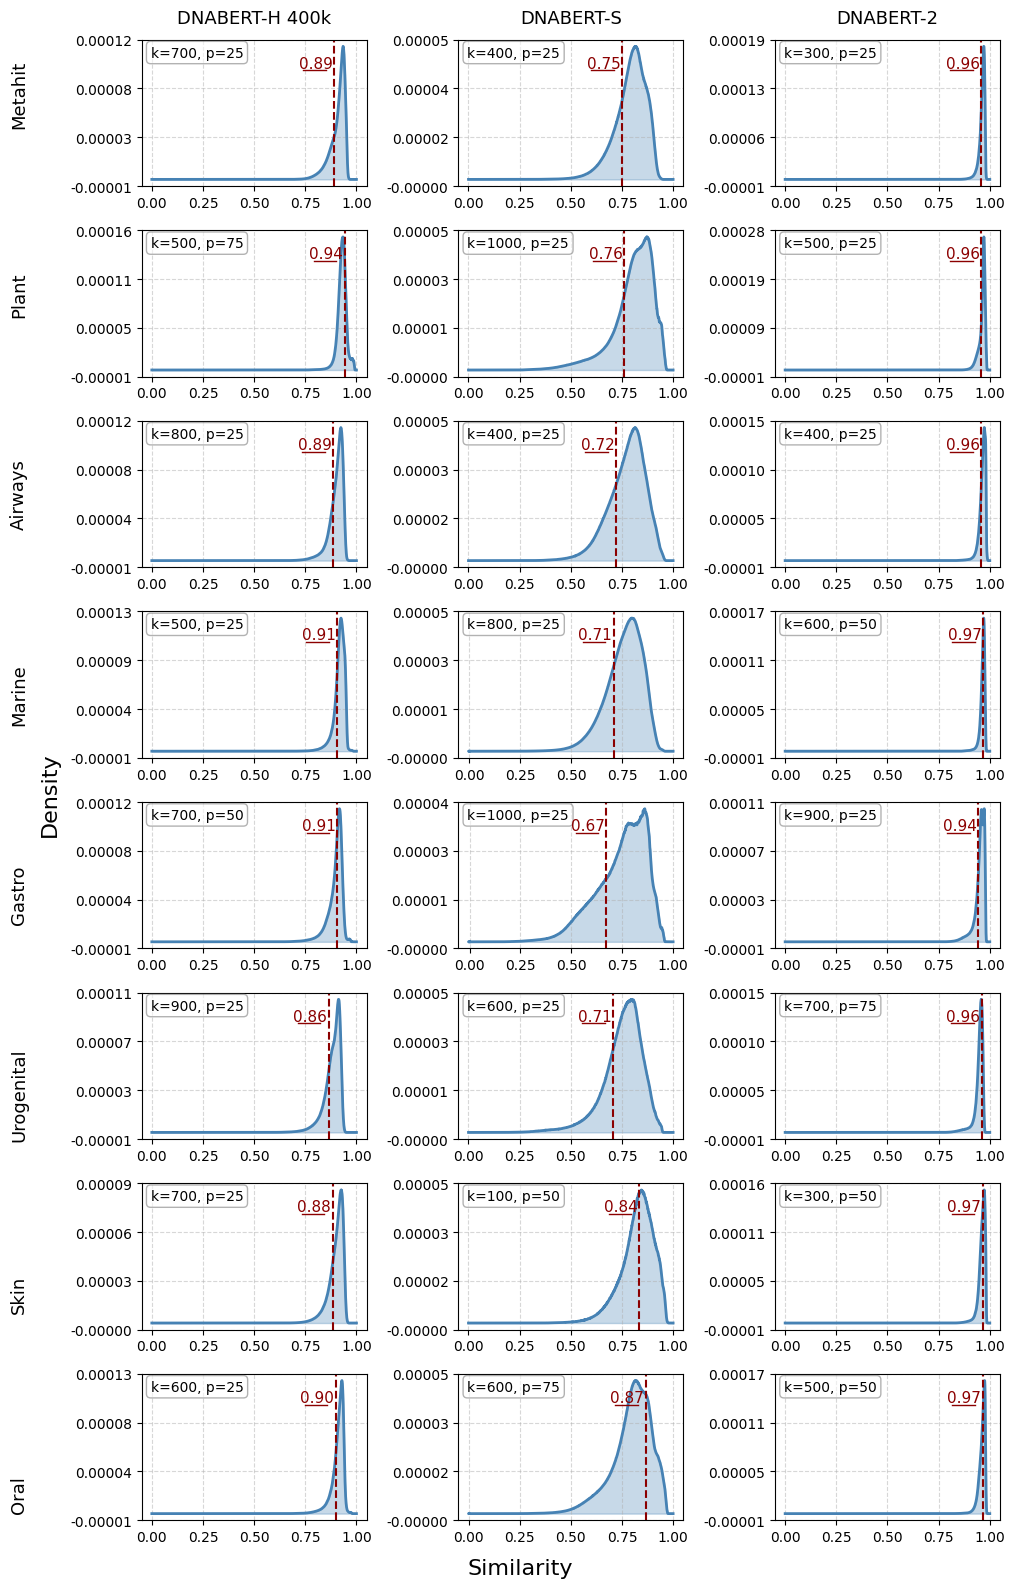

In [17]:
plot_histograms(knn_data, MODELS[:3], MODEL_NAMES[:3])

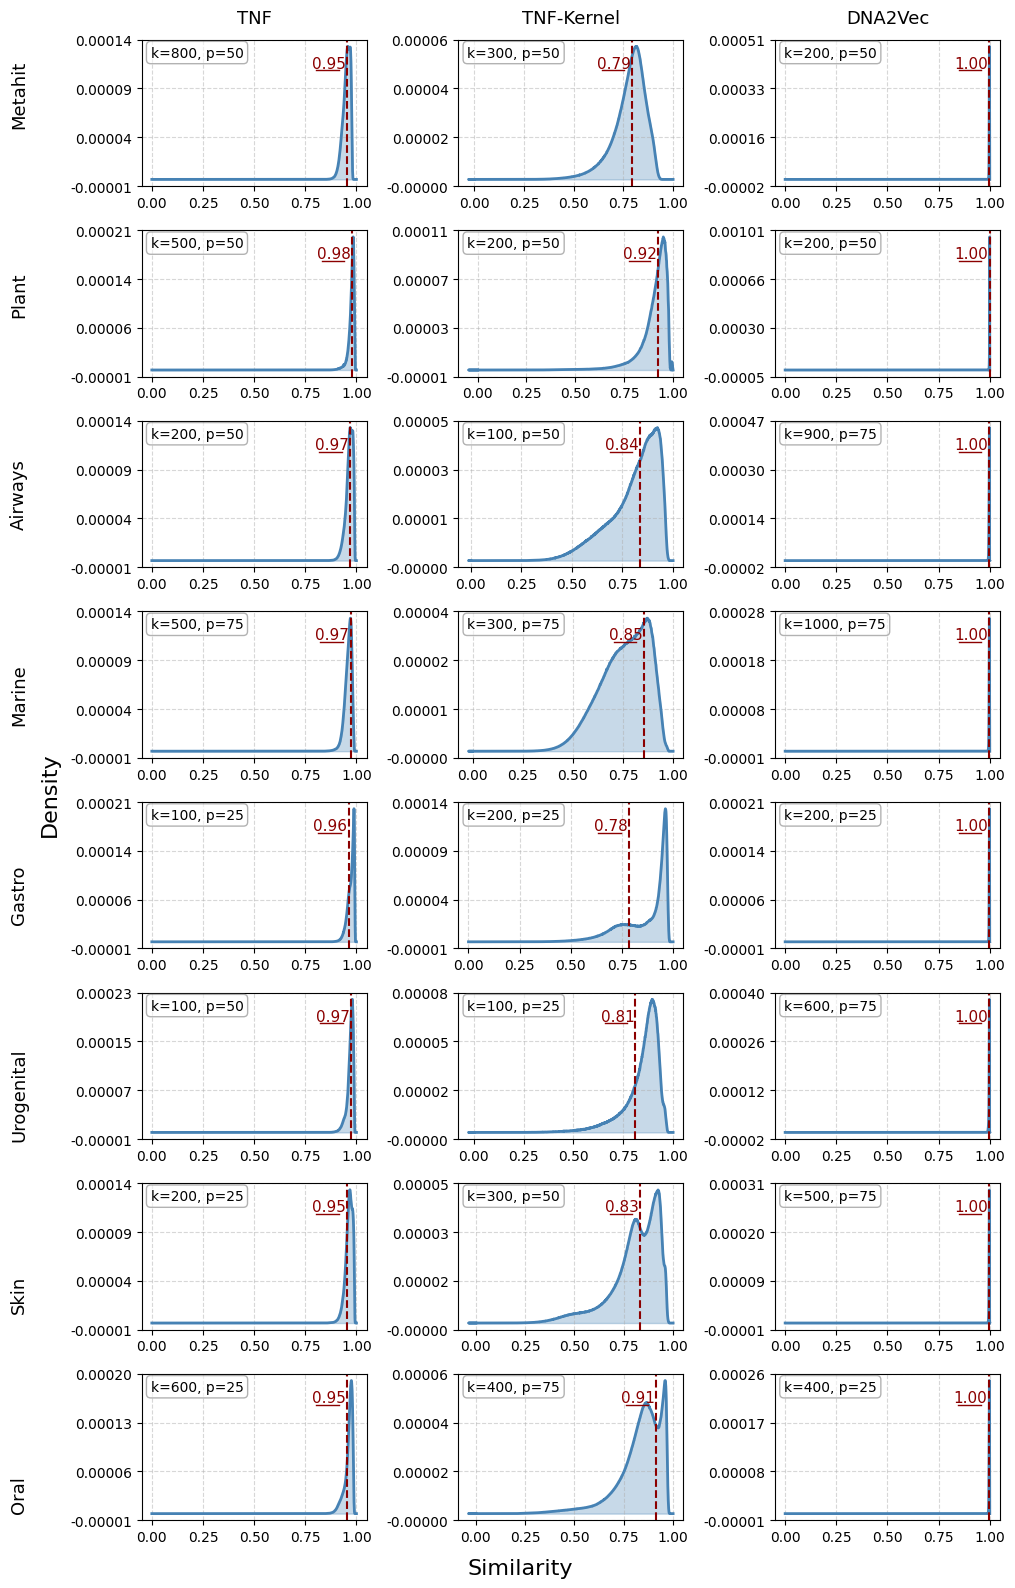

In [13]:
plot_histograms(knn_data, MODELS[3:6], MODEL_NAMES[3:6])

## Heatmaps

In [18]:
model_names_heatmaps = {
    'vamb': 'VAMB',
    'taxvamb': 'TaxVAMB',
    'comebin': 'Comebin',
    'dnaberts': 'DNABERT-S',
    'dnaberth': 'DNABERT-H 400k',
    'dnabert2': 'DNABERT-2',
    'dnabert2random': 'DNABERT2-Random',
    'tnf': 'TNF',
    'tnfkernel': 'TNF-Kernel',
    'dna2vec': 'DNA2Vec'
}

In [19]:
heatmaps = pd.read_csv(os.path.join(RESULTS_DIR, 'heatmaps.csv'), sep=',')

In [20]:
def plot_heatmaps(results_df: pd.DataFrame, models_to_plot: list[str], max_plots=8, datasets_to_plot=None):
    """
    For each model in `models_to_plot`, plots up to 8 heatmaps (for datasets) in a 4x2 grid per figure.
    X and Y axes are swapped (K on x-axis, Percentile on y-axis).
    Dataset names are cleaned (_short removed and capitalized).
    """

    if datasets_to_plot is None:
        datasets_to_plot = DATASET_ORDER
    else:
        datasets_to_plot = [ds for ds in DATASET_ORDER if ds in datasets_to_plot]

    results_df['heatmap'] = results_df['heatmap'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

    for model in models_to_plot:
        print(f"PLOT FOR ------{model}")
        model_df = results_df[(results_df['model'] == model) & (results_df['dataset'].isin(datasets_to_plot))]
        model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
        model_df = model_df.sort_values('dataset')

        n_plots = min(len(model_df), max_plots)
        n_cols = 4
        n_rows = math.ceil(n_plots / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.2 * n_cols, 2.3 * n_rows))
        axes = axes.flatten()

        # Create a new axis for the color bar (to the right of the last plot)
        cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # Adjust the position for color bar

        # Find the global min and max for color scale within the model
        min_val = float('inf')
        max_val = float('-inf')

        # Loop through each dataset in the model and calculate the global min and max values
        for _, row in model_df.head(max_plots).iterrows():
            heatmap_dict = row['heatmap']
            df = pd.DataFrame(heatmap_dict)
            df.index = df.index.astype(int)  # Percentiles
            df.columns = df.columns.astype(int)  # Ks

            df = df.sort_index(axis=0, ascending=False)  # Reverse the order of percentiles (Y-axis)
            df = df.sort_index(axis=1)  # K (X-axis)

            # Update min and max values for color scale
            min_val = min(min_val, df.values.min())
            max_val = max(max_val, df.values.max())

        # Loop over each subplot to plot the heatmap with consistent color scale within the model
        for i, (_, row) in enumerate(model_df.head(max_plots).iterrows()):
            heatmap_dict = row['heatmap']
            df = pd.DataFrame(heatmap_dict)
            df.index = df.index.astype(int)  # Percentiles
            df.columns = df.columns.astype(int)  # Ks

            df = df.sort_index(axis=0, ascending=False)  # Reverse the order of percentiles (Y-axis)
            df = df.sort_index(axis=1)  # K (X-axis)

            pretty_name = row['dataset'].replace('_short', '').capitalize()

            # Plot the heatmap for each dataset with consistent color scale within the model
            sns.heatmap(
                df.values,
                annot=True,
                fmt=".2f",
                cmap="flare",
                cbar=True,  # Ensure color bar is included
                linewidths=0.5,
                xticklabels=df.columns,
                yticklabels=df.index,
                ax=axes[i],
                cbar_ax=cbar_ax,  # Ensure all plots share the color bar
                vmin=min_val,  # Set the color scale minimum within the model
                vmax=max_val   # Set the color scale maximum within the model
            )
            axes[i].set_title(pretty_name)

            # Set Y-axis labels only for the 1st and 5th plot (0-indexed 0 and 4)
            if i != 0 and i != 4:
                axes[i].set_yticklabels([])

            # Set X-axis labels only for the 5th, 6th, 7th, and 8th plot (0-indexed 4, 5, 6, 7)
            if i < 4 or i > 7:
                axes[i].set_xticklabels([])

        # Hide unused subplots
        for j in range(n_plots, len(axes)):
            axes[j].axis('off')

        # Common x and y labels
        #fig.suptitle(f"{model_names_heatmaps[model]}", fontsize=16)
        fig.supxlabel("K Neighbors", fontsize=12)
        fig.supylabel("Percentile (P)", fontsize=12, x=0)  # Move the Y-axis label further left
        
        # Adjust layout for common color bar
        plt.tight_layout(rect=[0, 0, 0.9, 0.95])
        #plt.savefig(os.path.join(OUT_DIR, "heatmaps_knn", f'{model}.svg'), bbox_inches='tight')
        plt.show()

In [ ]:
##TO do : REMOVE THE 0 BEFORE THE ., e.g. 0.15 -> .15

PLOT FOR ------dnaberth_400k


C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


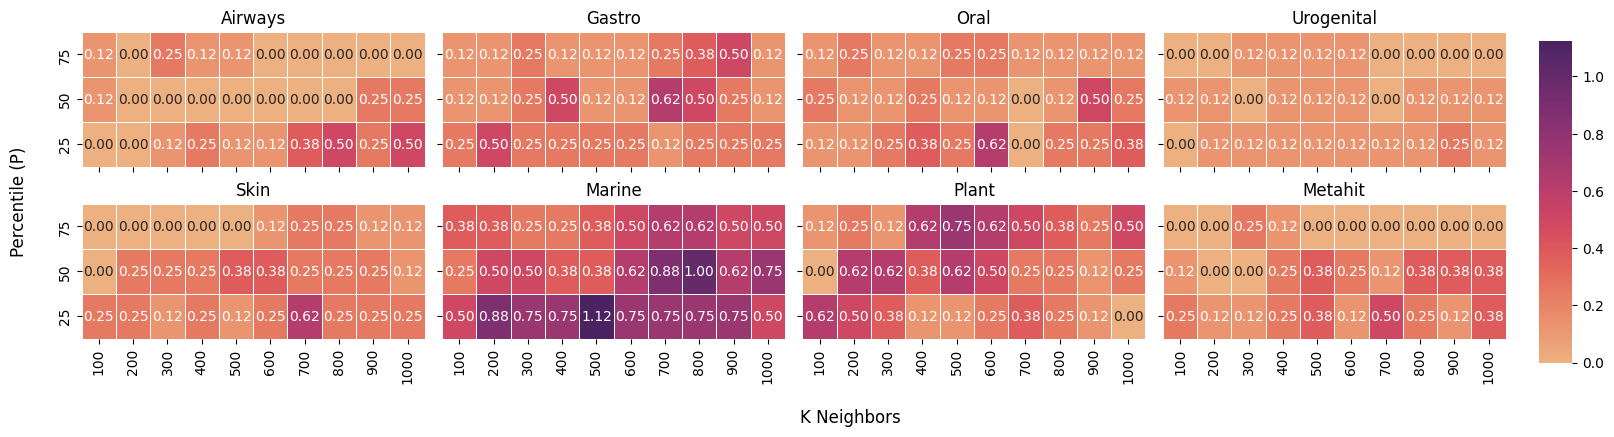

PLOT FOR ------dnaberts


C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


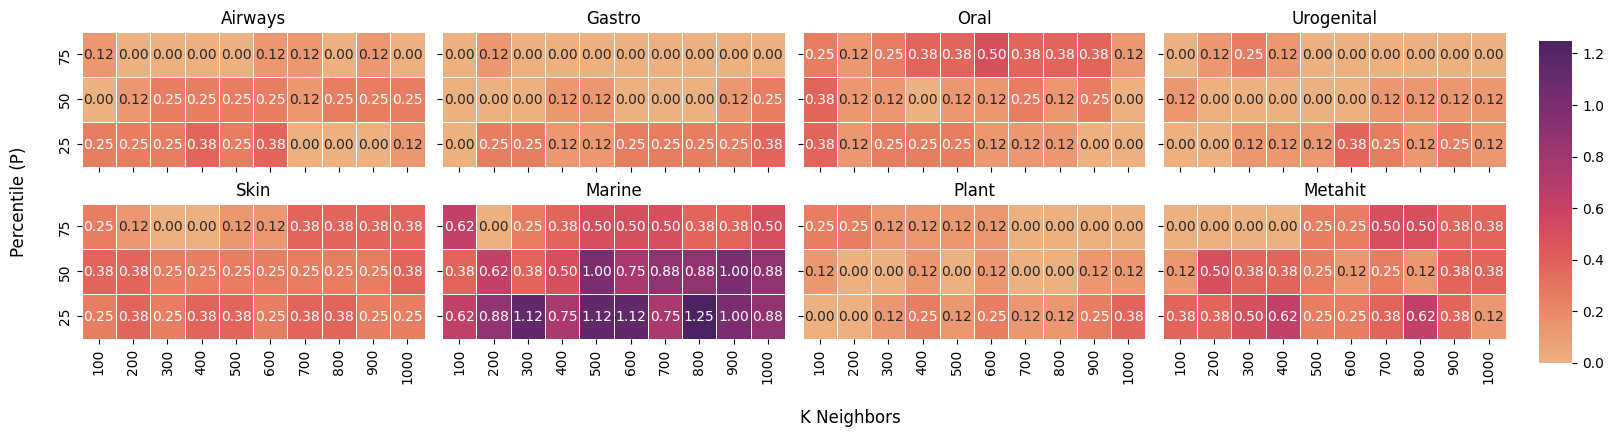

PLOT FOR ------dnabert2


C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


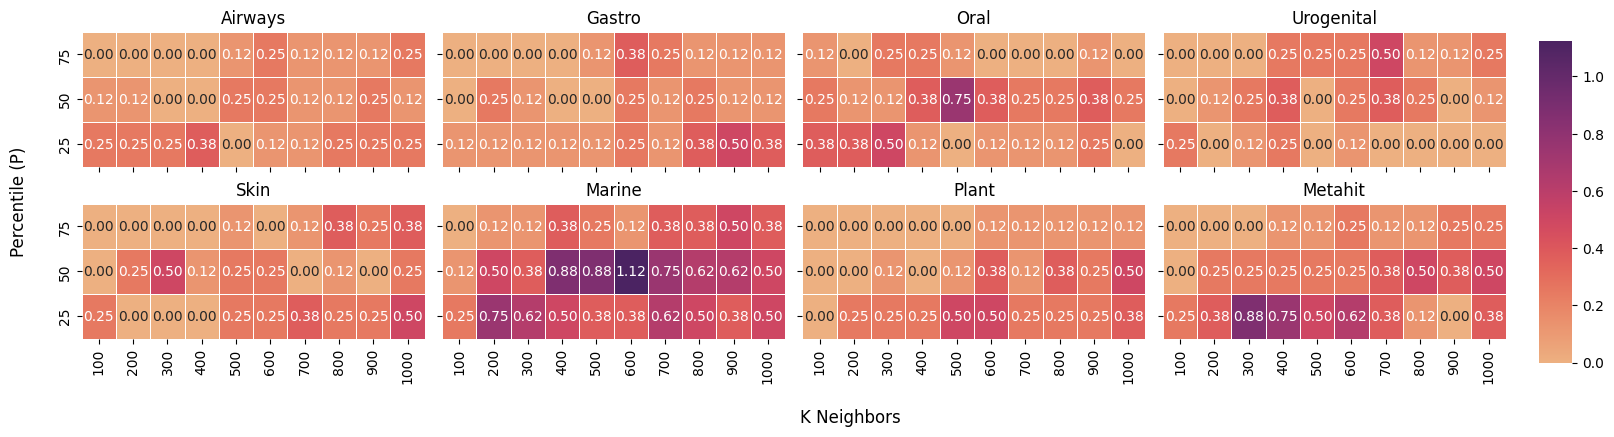

PLOT FOR ------dnabert2random


C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


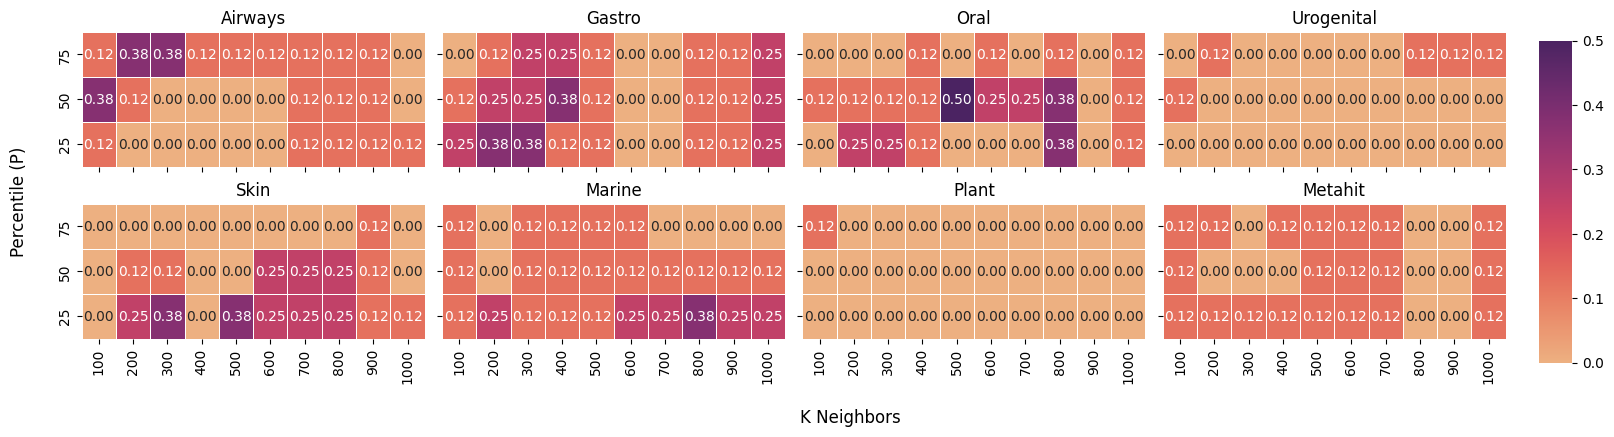

PLOT FOR ------tnf


C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


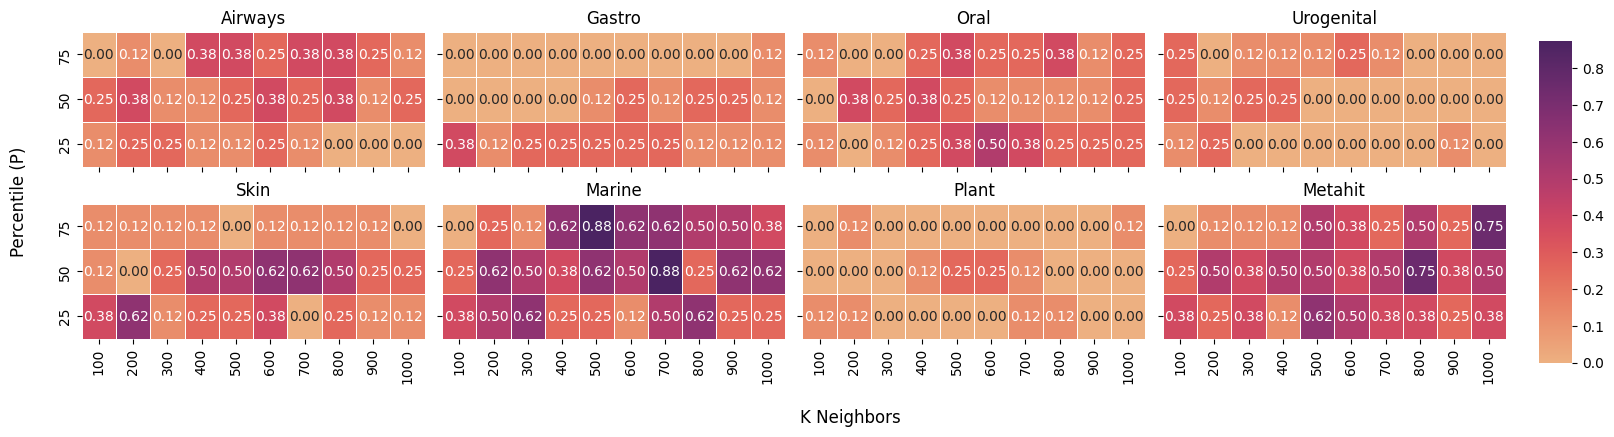

PLOT FOR ------tnfkernel


C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['dataset'] = pd.Categorical(model_df['dataset'], categories=datasets_to_plot, ordered=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_4256\3942826778.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


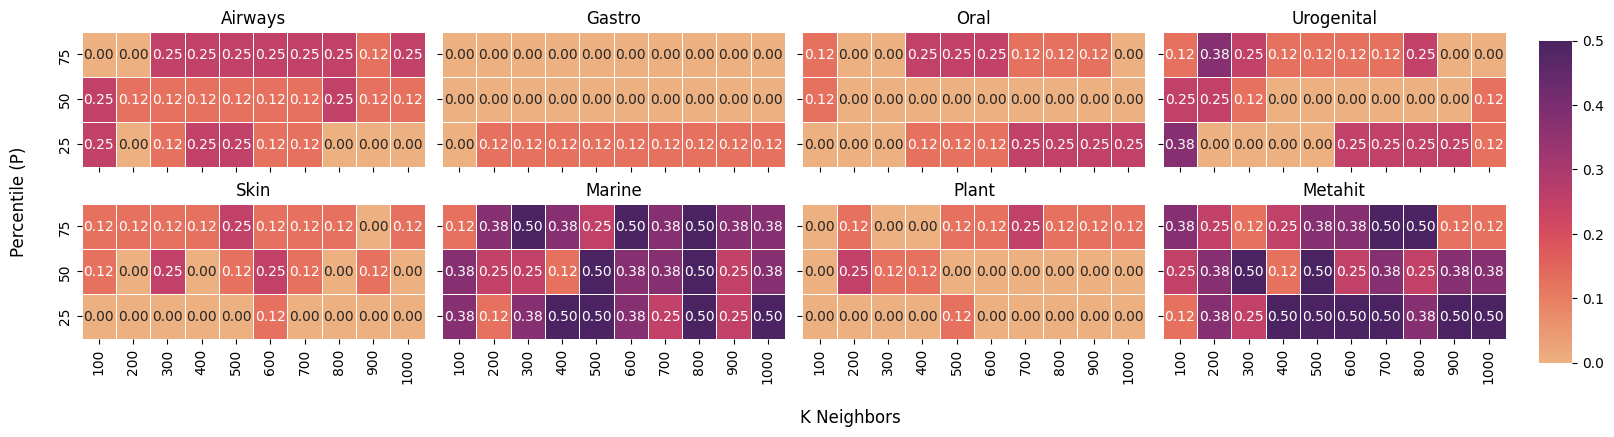

In [21]:
plot_heatmaps(heatmaps, models_to_plot=MODELS[:6])
#plot_heatmaps(heatmaps, models_to_plot=MODELS[3:6])

## Contig length histograms

In [4]:
with open(os.path.join(RESULTS_DIR, 'parsed_contig_lengths.json'), 'r') as f:
    contig_data = json.load(f)
contig_data = {key: contig_data[key] for key in DATASET_ORDER if key in contig_data}

C:\Users\ah140\AppData\Local\Temp\ipykernel_1600\1885311036.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


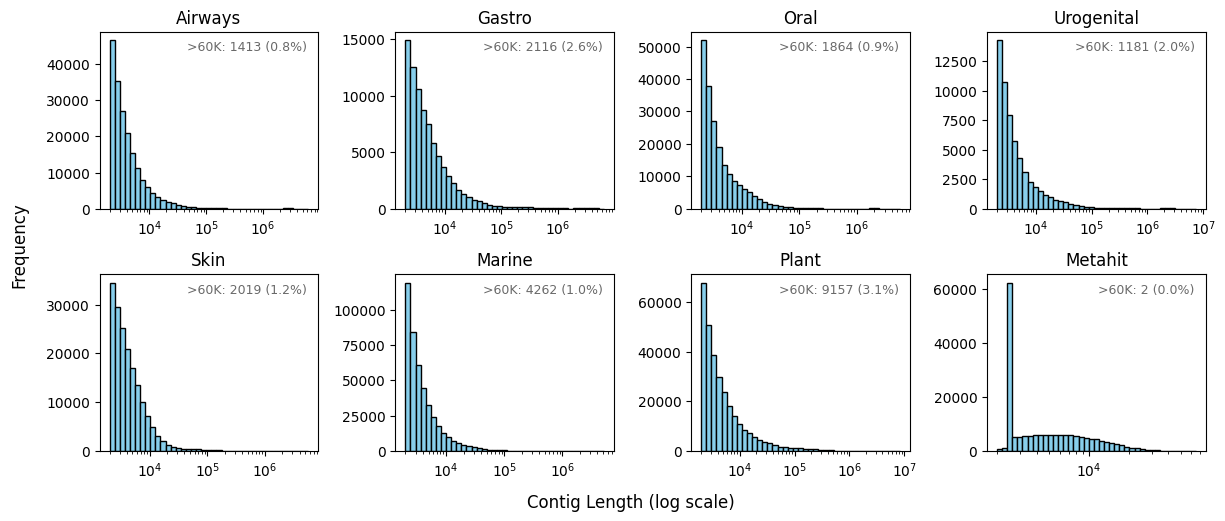

In [25]:
# Parameters
n_cols = 4
n_rows = 2
min_length = 2000
highlight_threshold = 60000  # threshold to count lengths above

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for idx, (dataset, lengths) in enumerate(contig_data.items()):
    ax = axes[idx]
    # Ensure lengths is a numpy array for min/max operations
    arr = np.array(lengths)

    # Compute log-spaced bins
    min_edge = max(arr.min(), min_length)
    max_edge = arr.max()
    bins = np.logspace(np.log10(min_edge), np.log10(max_edge), 40)

    # Plot histogram on log scale
    ax.hist(arr, bins=bins, color='skyblue', edgecolor='black')
    ax.set_xscale('log')

    # Count how many lengths exceed the threshold
    count_above = np.sum(arr >= highlight_threshold)

    # Title and annotations
    ax.set_title(dataset.replace('_short', '').capitalize())
    # Display count above threshold
    ax.text(
        0.95, 0.95,
        f'>60K: {count_above} ({count_above / len(arr) * 100:.1f}%)',
        ha='right', va='top', transform=ax.transAxes,
        fontsize=9, color='dimgrey'
    )

    # Format ticks: use log ticks
    ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=5))
    ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
    ax.xaxis.set_minor_formatter(plt.NullFormatter())

# Global labels
fig.text(0.5, -0.015, 'Contig Length (log scale)', ha='center', va='center', fontsize=12)
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'seq_len_hist_log.svg'), bbox_inches='tight')
plt.show()

airways_short 1877
gastro_short 817
oral_short 2016
urogenital_short 578
skin_short 1740
marine_short 4391
plant_short 3003
metahit 1796


C:\Users\ah140\AppData\Local\Temp\ipykernel_1600\3995550.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


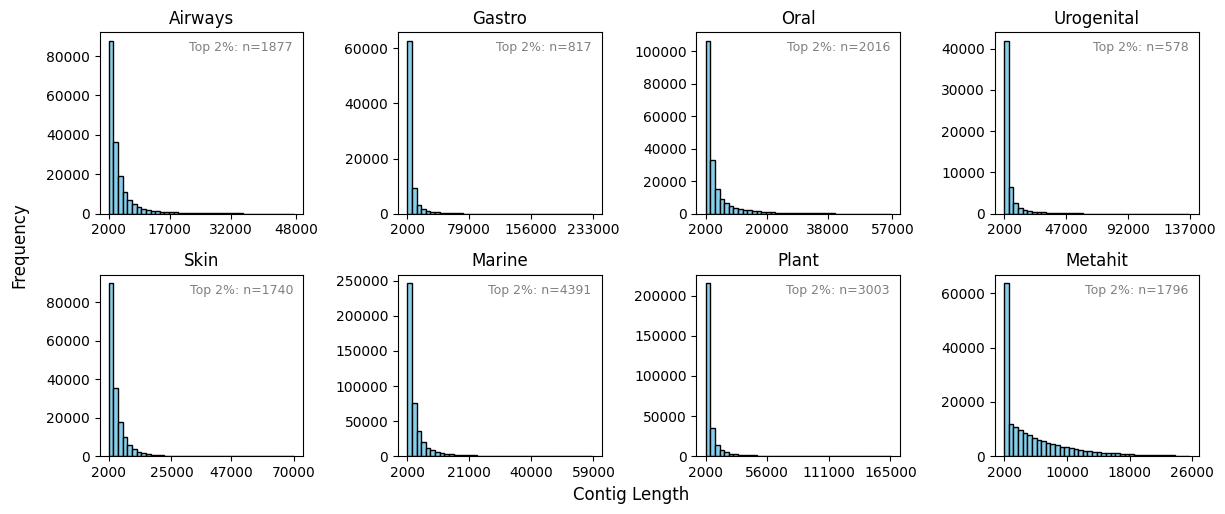

In [7]:
# Plot setup
n_cols = 4
n_rows = 2
percentile = 98
min_length = 2000

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for idx, (dataset, lengths) in enumerate(contig_data.items()):
    ax = axes[idx]
    top_1_percentile = np.percentile(lengths, 99)
    top_1_count = sum(l > top_1_percentile for l in lengths)
    print(dataset, top_1_count)
    ax.hist(lengths, bins=40, color='skyblue', range=(min_length, top_1_percentile), edgecolor='black')
    ax.set_title(dataset.replace('_short','').capitalize())
    ax.text(0.95, 0.95, f'Top {100-percentile}%: n={top_1_count}', ha='right', va='top', transform=ax.transAxes, fontsize=9, color='grey') 
    ticks = np.linspace(min_length, top_1_percentile, 4)  
    ticks = np.round(ticks / 1000) * 1000
    ax.set_xticks(ticks)
    
fig.text(0.5, 0.0, 'Contig Length', ha='center', va='center', fontsize=12)  # X-axis label
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=12) 

plt.tight_layout()
#plt.savefig(os.path.join(OUT_DIR, 'seq_len_hist.svg'), bbox_inches='tight')
plt.show()

## T-SNE on Hausdorff Distances

In [23]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# ha = np.load('hausdorff_distances.npz')
# cn = ha['cluster_names']
# dist = ha['distance_matrix']

# # Run t-SNE
# tsne = TSNE(n_components=2, metric='precomputed', random_state=42, init='random', perplexity=17)
# tsne_results = tsne.fit_transform(dist)

# # Plot
# fig, ax = plt.subplots(figsize=(6, 6))

# ax.scatter(
#     tsne_results[:, 0], 
#     tsne_results[:, 1], 
#     c='steelblue',  # single color for all points
#     s=60, 
#     alpha=0.8, 
#     edgecolors='w',
#     linewidth=0.5
# )

# # Remove axes for a clean look
# ax.set_xticks([])
# ax.set_yticks([])
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# ax.set_title('t-SNE of Distance Matrix (No Labels)', fontsize=14, fontweight='bold')
# plt.tight_layout(pad=2.0)

# plt.show()